In [2]:
#To prepare for model training, we import the necessary functions and submodules from keras

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.utils import normalize, to_categorical
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib import pyplot
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [3]:

    df = pd.read_csv("eif3a_full_150.csv")
    # print(df)

    train_All_1 = df.iloc[:, 2]
    test_all_1 = df.iloc[:, 3]

    pos_train_seq = train_All_1[0:711, ]
    neg_train_seq = train_All_1[711:, ]
    pos_test_seq = test_all_1[0:45, ]
    neg_test_seq = test_all_1[45:90, ]

In [4]:
    import onehot as ot
    X_train = np.array(train_All_1)
    # a = X_train[1]
    # print(len(a))

    lt = []
    for seq in X_train:
        x = ot.seq_to_mat(seq)
        lt.append(x)
    x_train = np.array(lt)
    print(x_train.shape)


    lst_test = []
    X_test = np.array(test_all_1[0:90])

    for seqs in X_test:
        x = ot.seq_to_mat(seqs)
        lst_test.append(x)

    x_test = np.array(lst_test)

    y_train = np.array([True, False])
    y_train = y_train.repeat(711)
    y_train = np.mat(y_train).transpose()
    # y_train = to_categorical(y_train)
    # print(y_train)

    y_test = np.array([True, False])
    y_test = y_test.repeat(45)
    y_test = np.mat(y_test).transpose()
    # y_test = to_categorical(y_test)

    # print(X_train)
    # print(y_train)
    # print(X_test)
    # print(y_test)


    print("x_train", x_train.shape)
    print('x_test', x_test.shape)
    print('y_test', y_test.shape)
    print('y_train', y_train.shape)

(1422, 151, 4)
x_train (1422, 151, 4)
x_test (90, 151, 4)
y_test (90, 1)
y_train (1422, 1)


In [4]:
x_train.shape[1::]




(151, 4)

In [5]:
#Define the model architecture in keras
one_filter_keras_model=Sequential()
one_filter_keras_model.add(Conv1D(filters=90,kernel_size=7,padding="valid",input_shape=x_train.shape[1::]))
one_filter_keras_model.add(Activation('relu'))
one_filter_keras_model.add(MaxPooling1D(pool_size=4,strides=2))
one_filter_keras_model.add(Dropout(0.25))

one_filter_keras_model.add(Conv1D(filters=100,kernel_size=5,padding="valid"))
one_filter_keras_model.add(Activation('relu'))
one_filter_keras_model.add(MaxPooling1D(pool_size=10,strides=5))
one_filter_keras_model.add(Dropout(0.25))

one_filter_keras_model.add(Flatten())
one_filter_keras_model.add(Dense(1421))
one_filter_keras_model.add(Activation("relu"))
one_filter_keras_model.add(Dense(1))
one_filter_keras_model.add(Activation("sigmoid"))
one_filter_keras_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 145, 90)           2610      
_________________________________________________________________
activation_1 (Activation)    (None, 145, 90)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 71, 90)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 90)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 67, 100)           45100     
_________________________________________________________________
activation_2 (Activation)    (None, 67, 100)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 100)          

In [6]:
def precision(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
	precision = true_positives / (predicted_positives + K.epsilon())
	return precision

def recall(y_true, y_pred):
	true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
	possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
	recall = true_positives / (possible_positives + K.epsilon())
	return recall


In [7]:
adam=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
one_filter_keras_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',precision,recall])

In [8]:
## save the best weight
# filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [9]:
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [10]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
callbacks_list = [earlyStopping,mcp_save,reduce_lr_loss]


/anaconda3/envs/DL/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [11]:
history = one_filter_keras_model.fit(x_train, y_train, batch_size=128, epochs=3,validation_data=(x_test,y_test),callbacks=callbacks_list)

Train on 1422 samples, validate on 90 samples
Epoch 1/3
1422/1422 [==============================] - 6s 4ms/step - loss: 3.3537 - accuracy: 0.5141 - precision: 0.2712 - recall: 0.1242 - val_loss: 0.6907 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

In [ ]:
# one_filter_keras_model.load_weights("weights-improvement-01-0.87.hdf5")


In [18]:
print(history.epoch)
a = history.epoch
print(len(a))

x=np.arange(3)+1
print(x)

[0, 1, 2]
3
[1 2 3]


In [15]:
# print(x_test)
results= one_filter_keras_model.evaluate(x_test,y_test)
print(results)
# print("loss=",loss)
# print("accuracy=",acc)

90/90 [==============================] - 0s 2ms/step
[0.48434309562047323, 0.7444444298744202, 0.5303030014038086, 0.6041666865348816]


In [16]:
%matplotlib inline

In [ ]:
epochs = np.arange(40) + 1
plt.plot(epochs, one_filter_keras_model, label='Original Model')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()



In [19]:
history


In [37]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score
y_pred_keras = one_filter_keras_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc

auc_keras = auc(fpr_keras, tpr_keras)

print(auc_keras)
# print(fpr_keras,tpr_keras,thresholds_keras)

0.8832098765432099
[0.         0.         0.         0.02222222 0.02222222 0.06666667
 0.06666667 0.11111111 0.11111111 0.15555556 0.15555556 0.2
 0.2        0.22222222 1.        ] [0.         0.02222222 0.35555556 0.35555556 0.73333333 0.73333333
 0.77777778 0.77777778 0.8        0.8        0.82222222 0.82222222
 0.84444444 0.84444444 1.        ] [1.9769799  0.97697985 0.79943573 0.7744346  0.41900116 0.31807438
 0.31068802 0.30207282 0.2938267  0.2855789  0.28476524 0.2827502
 0.28252864 0.28246492 0.2823337 ]


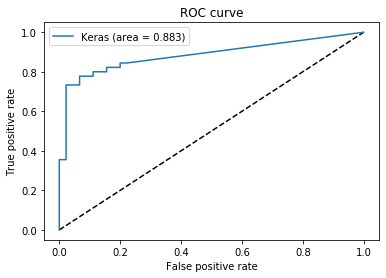

In [38]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

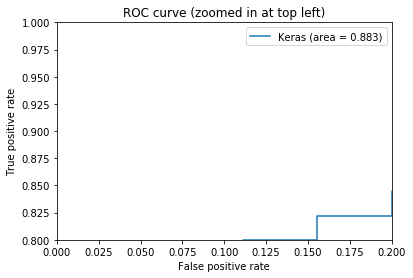

In [39]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [12]:
lr_probs = one_filter_keras_model.predict_proba(x_test)
# keep probabilities for the positive outcome only

print(lr_probs)
# lr_probs = lr_probs[:, 1]
#

[[0.5045076 ]
 [0.47508624]
 [0.5278096 ]
 [0.45292902]
 [0.52813256]
 [0.46620157]
 [0.5104461 ]
 [0.52279305]
 [0.43938935]
 [0.52773756]
 [0.5135595 ]
 [0.52721757]
 [0.3881876 ]
 [0.39215168]
 [0.4084068 ]
 [0.52875865]
 [0.52847457]
 [0.50378567]
 [0.38862222]
 [0.38052267]
 [0.5283583 ]
 [0.527913  ]
 [0.5281304 ]
 [0.5281392 ]
 [0.3904862 ]
 [0.47373393]
 [0.4614972 ]
 [0.451212  ]
 [0.49745888]
 [0.52800965]
 [0.52408147]
 [0.52175754]
 [0.47982258]
 [0.45948195]
 [0.51113856]
 [0.48545033]
 [0.52363586]
 [0.5043782 ]
 [0.50434005]
 [0.52856314]
 [0.528477  ]
 [0.5173181 ]
 [0.49781078]
 [0.5103447 ]
 [0.51573086]
 [0.39229098]
 [0.520622  ]
 [0.46820658]
 [0.49283263]
 [0.507683  ]
 [0.38952643]
 [0.4543119 ]
 [0.43243718]
 [0.4825369 ]
 [0.43135208]
 [0.40087152]
 [0.41269755]
 [0.44071743]
 [0.4152276 ]
 [0.34742868]
 [0.44045877]
 [0.42115778]
 [0.43796682]
 [0.38777775]
 [0.40602228]
 [0.4336722 ]
 [0.4983193 ]
 [0.38166198]
 [0.45238754]
 [0.4814667 ]
 [0.41565108]
 [0.36

0.9152724748949133
CNN:  auc=0.915


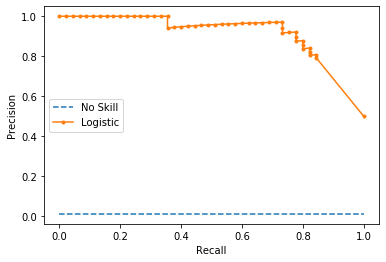

In [64]:
# predict class values
yhat = one_filter_keras_model.predict(x_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

# print(yhat)
# print(y_test)

# lr_f1 = f1_score(y_test, yhat)
lr_auc=auc(lr_recall, lr_precision)
print(lr_auc)

# summarize scores
print('CNN:  auc=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [66]:
max(history.history['accuracy'])

0.7475387

In [17]:
from sklearn.metrics import matthews_corrcoef
yhat = one_filter_keras_model.predict_classes(x_test)
print(yhat)

[[1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [ ]:
y_test = np.array([1, 0])
y_test = y_test.repeat(45)
y_test = np.mat(y_test).transpose()
print(y_test)

In [19]:
matthews_corrcoef(y_test,yhat)

0.5943962929568426

In [21]:
print(yhat)

[[1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [22]:
print(y_test)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [25]:
a =0.2
b=0.4
x=0.6
c = 0.7

In [28]:
matrix = np.arange(0,4)
print(matrix)

[0 1 2 3]


In [31]:
z=np.array([a,b,x,c])
np.savetxt('new.csv', z, delimiter = ',')